# Transfer Learning with MobileNetV2

## Achieved accuracy 98.12 on the test dataset

## Accomplished by Nima Farnoodian and Atefeh Bahrami

## Adopted from Andrew Ng's Convolutional NN course

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from keras.preprocessing.image import ImageDataGenerator


In [2]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator()
evaluate_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(
    'dataset/training', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    'dataset/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

Found 3586 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [3]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [4]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [5]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [6]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [7]:
# UNQ_C2
# GRADED FUNCTION
def jewelry_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    x =inputs

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(units=1, activation='sigmoid')
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [8]:
model2 = jewelry_model(IMG_SIZE)

In [9]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
initial_epochs = 5
history = model2.fit_generator(train_generator, validation_data=test_generator, epochs=initial_epochs)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
113/113 [==============================] - 88s 743ms/step - loss: 0.3839 - accuracy: 0.8160 - val_loss: 0.0899 - val_accuracy: 0.9750
Epoch 2/5
113/113 [==============================] - 63s 556ms/step - loss: 0.0750 - accuracy: 0.9799 - val_loss: 0.0695 - val_accuracy: 0.9771
Epoch 3/5
113/113 [==============================] - 64s 562ms/step - loss: 0.0598 - accuracy: 0.9811 - val_loss: 0.0499 - val_accuracy: 0.9833
Epoch 4/5
113/113 [==============================] - 62s 552ms/step - loss: 0.0449 - accuracy: 0.9846 - val_loss: 0.0438 - val_accuracy: 0.9875
Epoch 5/5
113/113 [==============================] - 66s 584ms/step - loss: 0.0489 - accuracy: 0.9824 - val_loss: 0.0473 - val_accuracy: 0.9854


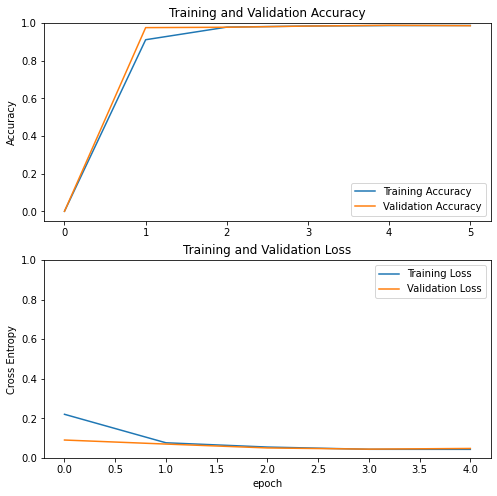

In [11]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [13]:
# UNQ_C3
#base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True


loss_function=tf.keras.losses.BinaryCrossentropy(
    from_logits=True,name='binary_crossentropy')
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [14]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit_generator(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_generator)

Epoch 5/10
113/113 [==============================] - 66s 555ms/step - loss: 0.0402 - accuracy: 0.9853 - val_loss: 0.0458 - val_accuracy: 0.9854
Epoch 6/10
113/113 [==============================] - 58s 516ms/step - loss: 0.0366 - accuracy: 0.9881 - val_loss: 0.0471 - val_accuracy: 0.9854
Epoch 7/10
113/113 [==============================] - 58s 509ms/step - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.0494 - val_accuracy: 0.9812
Epoch 8/10
113/113 [==============================] - 66s 581ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0450 - val_accuracy: 0.9854
Epoch 9/10
113/113 [==============================] - 63s 555ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0420 - val_accuracy: 0.9854
Epoch 10/10
113/113 [==============================] - 61s 542ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0429 - val_accuracy: 0.9854


In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

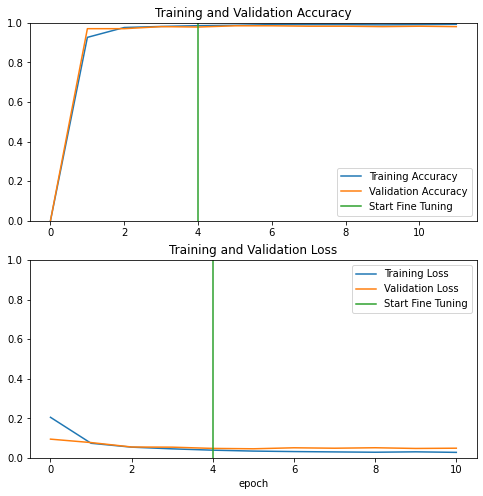

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
score = model2.evaluate_generator(test_generator)
print("Loss : ", score[0])
print("Accuracy on test photos: ", score[1])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss :  0.04853654280304909
Accuracy on test photos:  0.981249988079071


In [3]:
# uncomment the following lines if you want to load the trained mobile_net model
from tensorflow import keras
model2 = keras.models.load_model("mobile_net.h5")

In [12]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    #print(np_image.shape)
    np_image = transform.resize(np_image, (160, 160, 3))
    #print(np_image.shape)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image



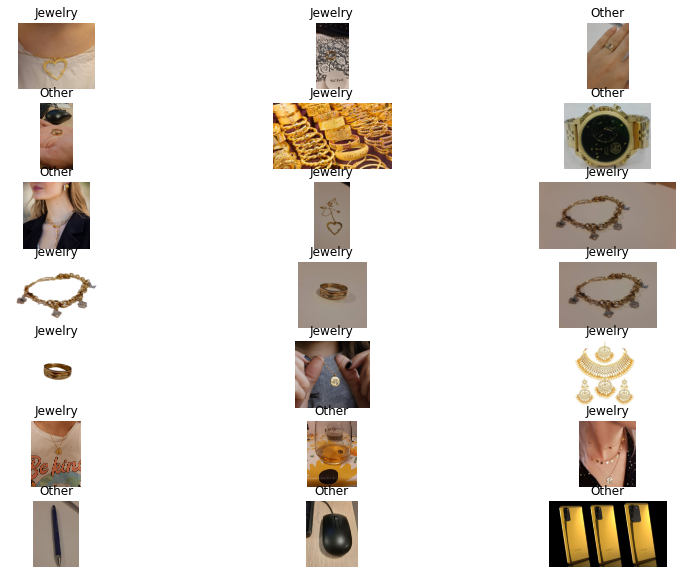

In [13]:
from PIL import Image
mypath="./test_to_show/"
from os import listdir
from os.path import isfile, join
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
count=0
plt.figure(figsize=(14, 10))
for img in images:
    test_image=Image.open(mypath+img)
    inp_org=np.array(test_image)
    #inp=np.array(test_image.resize((32,32)))
    #inp=inp
    #inp=inp.reshape((1,32,32,3))
    img = load(mypath+img)
    #classifier.predict(image)
    cls=model2.predict(img)
    if np.round(cls[0])==0:
        lbl="Jewelry"
    elif np.round(cls[0])==1:
        lbl="Other"
    #plot1 = plt.figure(count)
    ax = plt.subplot(7, 3, count + 1)
    plt.imshow(inp_org)
    plt.title(lbl)
    plt.axis("off")
    count+=1
